# **MA544**
## Academic Paper Ranking and Recommendations



1.   API
2.   Data Preprocessing
3.   Data Analysis
4.   Term Document Frequency and NMF
5.   Topic Clustering
6.   Recommender System and Topic Querying
7.   Conclusion



# Section 1

## API

In [ ]:
#@title Load Kaggle API (Enter kaggle API key) { display-mode: "form" }
!pip install -q kaggle

from google.colab import files

files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
#@title Download arXiv Dataset { vertical-output: false }
!kaggle datasets download Cornell-University/arxiv
!unzip arxiv.zip -d arxiv-dataset

arxiv.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  arxiv.zip
replace arxiv-dataset/arxiv-metadata-oai-snapshot.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
#check if got json

!ls arxiv-dataset

arxiv-metadata-oai-snapshot.json


In [ ]:
#@title Python Imports
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import NMF
from sklearn.preprocessing import normalize
import seaborn as sns
#from yellowbrick.text.tsne import tsne

### Dataset

In [ ]:
'''
arVix dataset, takes tags needed from metadata. call given categories of interest (instead of calling )
'''
class ArVixDataset:
  def __init__(self, file_path, tags):
    self.file_path = file_path
    self.tags = tags

  def __call__(self, categories):
    raw_data = {tag: [] for tag in self.tags}
    categories = [category.lower() for category in categories]
    with open(self.file_path, 'r') as f:
      for line in f:
        d = json.loads(line)
        if d["categories"].lower() in categories:
          for key, value in raw_data.items():
            raw_data[key] += [d[key]]

    return pd.DataFrame(raw_data)

In [ ]:
arvix = ArVixDataset("arxiv-dataset/arxiv-metadata-oai-snapshot.json", ["id", "submitter", "authors", "title", "categories", "abstract", "update_date"])
arvix_dataset = arvix(["hep-ph"])

In [ ]:
arvix_dataset

,id,submitter,authors,title,categories,abstract,update_date
0,0704.0001,Pavel Nadolsky,"C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-...",Calculation of prompt diphoton production cros...,hep-ph,A fully differential calculation in perturba...,2008-11-26
1,0704.0016,Li Tong,"Chao-Hsi Chang, Tong Li, Xue-Qian Li and Yu-Mi...",Lifetime of doubly charmed baryons,hep-ph,"In this work, we evaluate the lifetimes of t...",2008-12-18
2,0704.0029,Weizhen Deng,"Zhan Shu, Xiao-Lin Chen and Wei-Zhen Deng",Understanding the Flavor Symmetry Breaking and...,hep-ph,"In $\XQM$, a quark can emit Goldstone bosons...",2010-04-23
3,0704.0031,Valery M. Biryukov,"V. M. Biryukov (Serpukhov, IHEP)",Crystal channeling of LHC forward protons with...,hep-ph,"We show that crystal can trap a broad (x, x'...",2008-11-26
4,0704.0032,Andreu Esteban-Pretel,"A. Esteban-Pretel, R. Tom\`as and J. W. F. Valle",Probing non-standard neutrino interactions wit...,hep-ph,We analyze the possibility of probing non-st...,2008-11-26
...,...,...,...,...,...,...,...
78125,hep-ph/9912547,Martin McDermott,"M. McDermott, L. Frankfurt, V. Guzey, M. Strikman",Unitarity and the QCD-improved dipole picture,hep-ph,As a consequence of QCD factorization theore...,2011-09-13
78126,hep-ph/9912548,Juerg Gasser,J. Gasser,Chiral perturbation theory,hep-ph,I present an outline of chiral perturbation ...,2008-11-26
78127,hep-ph/9912549,Petre Golumbeanu,P. Golumbeanu and C. Rosenzweig,Escape of Superheated Upsilons from the Quark ...,hep-ph,The properties of heavy quark systems change...,2007-05-23
78128,hep-ph/9912551,Thomas Teubner,"A.D. Martin, M.G. Ryskin and T. Teubner",Q^2 dependence of diffractive vector meson ele...,hep-ph,We give a general formula for the cross sect...,2008-11-26


In [ ]:
arvix_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78130 entries, 0 to 78129
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           78130 non-null  object
 1   submitter    74518 non-null  object
 2   authors      78130 non-null  object
 3   title        78130 non-null  object
 4   categories   78130 non-null  object
 5   abstract     78130 non-null  object
 6   update_date  78130 non-null  object
dtypes: object(7)
memory usage: 4.2+ MB


In [ ]:
#convert date from string to datetime
arvix_dataset["update_date"] = pd.to_datetime(arvix_dataset["update_date"])

In [ ]:
arvix_dataset.sort_values(by='update_date')

,id,submitter,authors,title,categories,abstract,update_date
78129,hep-ph/9912553,Neil Russell,Neil Russell,Bounding CPT- and Lorentz-Violating Parameters...,hep-ph,A general theoretical framework that incorpo...,2007-05-23
43614,hep-ph/0111257,Honggong Wu,H. G. Wu,Fieldbus Device Drivers for Accelerator Contro...,hep-ph,In order to interface the DESY fieldbus adap...,2007-05-23
58583,hep-ph/0611044,Redamy Perez Ramos,Redamy Perez Ramos,"Hadronic distributions and correlations at ""sm...",hep-ph,We exactely calculate the inclusive transver...,2007-05-23
43615,hep-ph/0111258,J. F. de Troconiz,J. F. de Troc\'oniz and F. J. Yndur\'ain,Precision Determination of the Muon $g_{\mu}-2...,hep-ph,We present a summary of the results of two r...,2007-05-23
43621,hep-ph/0111265,Helmut Satz,H. Satz,Matter & More in Nuclear Collisions,hep-ph,The aim of high energy nuclear collisions is...,2007-05-23
...,...,...,...,...,...,...,...
37878,2212.03994,Gerardo Hern\'andez-Tom\'e,"Gerardo Hern\'andez-Tom\'e, Diego Portillo-S\'...",Resonant Majorana neutrino effects in $\Delta$...,hep-ph,We computed the $\Sigma^{-}\to n\pi^+e^-\ell...,2022-12-09
37877,2212.03889,Jordi Salvado,"Diego Blas, Ivan Esteban, M.C. Gonzalez-Garcia...",On neutrino-mediated potentials in a neutrino ...,hep-ph,The exchange of a pair of neutrinos with Sta...,2022-12-09
37876,2212.03883,Simon Knapen,"Simon Knapen, Steven Lowette",A guide to hunting long-lived particles at the...,hep-ph,This article is a pedagogical review to sear...,2022-12-09
37171,2208.08602,Michal Praszalowicz,Michal Praszalowicz,Doubly Heavy Tetraquarks in the Chiral Quark S...,hep-ph,Chiral Quark Soliton Model has been successf...,2022-12-09


# Section 2

## Data Preprocessing

Reduce abstracts into more qualtative information, related to the field. Removes stopwords, clutter, numbers, minor imperfections in abstracts.

In [ ]:
def clean_abstract(text):
  '''
  Returns cleaned abstract string for preparation of NLP analysis
  Handles:
   - newlines
   - latex math
   - extra whitespaces
   - punctuation
   - drop single letters
   - lowercase
   - stopwords
  '''
  text = re.sub(r'\n', ' ', text)
  text = re.sub(r'(\$+)(?:(?!\1)[\s\S])*\1', ' ', text)
  text = re.sub(r'[^\w\s]', ' ', text)
  text =  re.sub(r'\d+', ' ', text)
  text = text.split(' ')
  text = [word.lower() for word in text if len(word) > 1]

  stop_words = ["ourselves", "hers", "between", "yourself", "but", "again", "there", "about", "once", "during", "out", "very", "having", "with", "they", "own", "an", "be", "some", "for", "do", "its", "yours", "such", "into", "of", "most", "itself", "other", "off", "is", "s", "am", "or", "who", "as", "from", "him", "each", "the", "themselves", "until", "below", "are", "we", "these", "your", "his", "through", "don", "nor", "me", "were", "her", "more", "himself", "this", "down", "should", "our", "their", "while", "above", "both", "up", "to", "ours", "had", "she", "all", "no", "when", "at", "any", "before", "them", "same", "and", "been", "have", "in", "will", "on", "does", "yourselves", "then", "that", "because", "what", "over", "why", "so", "can", "did", "not", "now", "under", "he", "you", "herself", "has", "just", "where", "too", "only", "myself", "which", "those", "i", "after", "few", "whom", "t", "being", "if", "theirs", "my", "against", "a", "by", "doing", "it", "how", "further", "was", "here", "than"]

  text = [word for word in text if word not in stop_words]


  return text

#examples
for i in range(3):
  print(f"\nAbstract #{i}:\n")
  
  print(arvix_dataset.iloc[i]["abstract"])
  print("\n")

  print(clean_abstract(arvix_dataset.iloc[i]["abstract"]))


Abstract #0:

  A fully differential calculation in perturbative quantum chromodynamics is
presented for the production of massive photon pairs at hadron colliders. All
next-to-leading order perturbative contributions from quark-antiquark,
gluon-(anti)quark, and gluon-gluon subprocesses are included, as well as
all-orders resummation of initial-state gluon radiation valid at
next-to-next-to-leading logarithmic accuracy. The region of phase space is
specified in which the calculation is most reliable. Good agreement is
demonstrated with data from the Fermilab Tevatron, and predictions are made for
more detailed tests with CDF and DO data. Predictions are shown for
distributions of diphoton pairs produced at the energy of the Large Hadron
Collider (LHC). Distributions of the diphoton pairs from the decay of a Higgs
boson are contrasted with those produced from QCD processes at the LHC, showing
that enhanced sensitivity to the signal can be obtained with judicious
selection of events.




As seen, math written in LaTex, numbers, and many extra words, unecessary to understand the relevant words to an abstract are removed

# Section 3

## Data Analysis

In [ ]:
#Create document list-of-list
arxiv_documents = [clean_abstract(document) for document in list(arvix_dataset['abstract'])]

In [ ]:
avg_unq_words = [len(set(doc)) for doc in arxiv_documents]
avg_words = [len(doc) for doc in arxiv_documents]
avg_unq_words_ratio = [len(set(doc))/len(doc) for doc in arxiv_documents]
total_unq_words = [item for sublist in arxiv_documents for item in sublist]

print(f"Abstract info:\n Total Words: {len(total_unq_words)}\n Avg. Words per Doc: {1/len(arxiv_documents)*sum(avg_words)}\n Avg. Unique Words per Doc: {1/len(arxiv_documents)*sum(avg_unq_words)}\n Avg. Unique Words per Doc Ratio: {1/len(arxiv_documents)*sum(avg_unq_words_ratio)}\n\n Total Unique Words: {len(set(total_unq_words))}\n Total Unique Word Ratio: {len(set(total_unq_words))/len(total_unq_words)}")

Abstract info:
 Total Words: 4890604
 Avg. Words per Doc: 62.59572507359529
 Avg. Unique Words per Doc: 49.54984001023934
 Avg. Unique Words per Doc Ratio: 0.8216611299889428

 Total Unique Words: 33161
 Total Unique Word Ratio: 0.006780553076879666


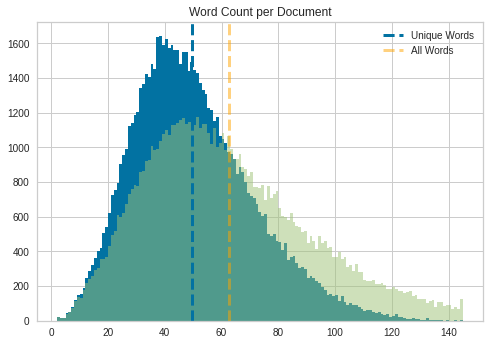

In [ ]:
bin_width = 1
plt.hist(avg_unq_words, bins=np.arange(min(avg_unq_words), max(avg_unq_words) + bin_width, bin_width))
plt.axvline(1/len(arxiv_documents)*sum(avg_unq_words), color='b', linestyle='dashed', linewidth=3)

plt.hist(avg_words, bins=np.arange(min(avg_unq_words), max(avg_unq_words) + bin_width, bin_width), alpha=0.5)
plt.axvline(1/len(arxiv_documents)*sum(avg_words), color='orange', linestyle='dashed', linewidth=3, alpha=0.5)
plt.title("Word Count per Document")
plt.legend(['Unique Words', 'All Words'])
plt.show()

From the above observations, both distributions are similar in skewness, with the unique words having a more centered distribution around 40~.



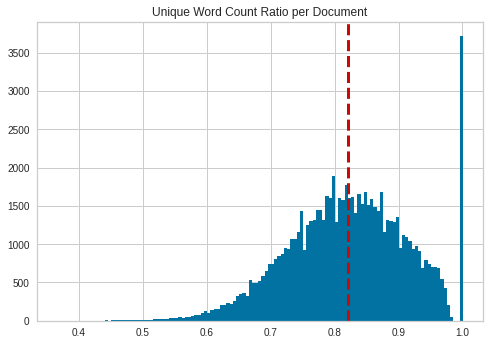

In [ ]:
bin_width = 0.005
plt.hist(avg_unq_words_ratio, bins=np.arange(min(avg_unq_words_ratio), max(avg_unq_words_ratio) + bin_width, bin_width))
plt.axvline(1/len(arxiv_documents)*sum(avg_unq_words_ratio), color='r', linestyle='dashed', linewidth=3)
plt.title("Unique Word Count Ratio per Document")
plt.show()

In [ ]:
word_dict = {}
seen_words = []
for doc in arxiv_documents:
    for word in doc:
        if word not in word_dict:
            word_dict[word] = 1
        else:
            word_dict[word] += 1

In [ ]:
count_words = sorted(word_dict.items(), key=lambda x: x[1])
k_words = 15
top_words = list(reversed(count_words))[:k_words]

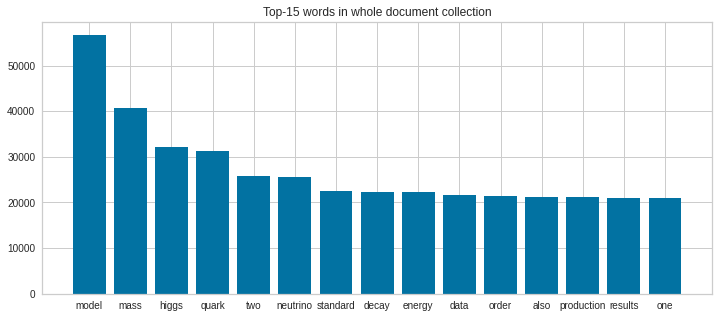

In [ ]:
plt.figure(figsize=(12,5))
plt.bar([k for (k,v) in top_words], [v for (k,v) in top_words])
plt.title(f"Top-{k_words} words in whole document collection")
plt.show()

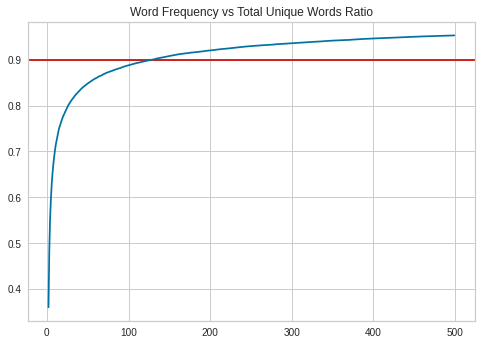

In [ ]:
lim = len(set(total_unq_words))
count_ratio = [len([_ for k, v in word_dict.items() if v < i])/lim for i in range(2, 500)]
plt.axhline(y=0.9, color='r', linestyle='-')
plt.plot(np.arange(2, 500), count_ratio)
plt.title("Word Frequency vs Total Unique Words Ratio")
plt.show()

We can observe, a word needs to occur ~100 times to be frequent enough in the dataset. So drop words infrequent words across all documents.

In [ ]:
from collections import Counter
infrequent_words = Counter([k for k, v in word_dict.items() if v < 100])

def reduce_document(doc):
  return [word for word in doc if word not in infrequent_words]

reduced_arxiv_documents = [' '.join(reduce_document(document)) for document in arxiv_documents]

# Section 4
## Term Document Frequency and NMF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

class TFIDF:
  def __init__(self):
    pass

  def __call__(self, documents):
    #Runs whole TDIDF process

    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(documents)


    return {"tfidf": X, "features": vectorizer.get_feature_names_out(), 'vec': vectorizer}

In [ ]:
TFIDF_model = TFIDF()

out = TFIDF_model(reduced_arxiv_documents)

<BarContainer object of 15 artists>

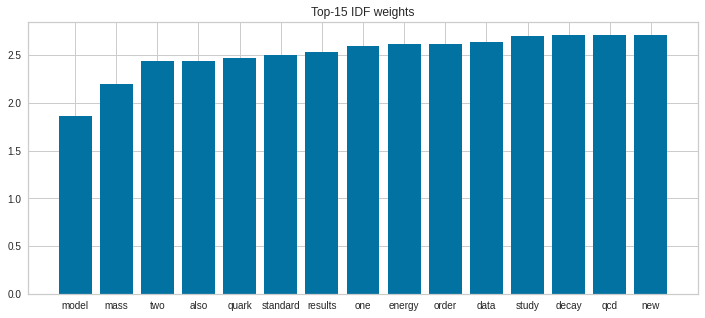

In [ ]:
plt.figure(figsize=(12,5))
top_k_idf_names = out['vec'].get_feature_names_out()[np.argsort(out['vec'].idf_)][:15]
top_k_idf_vals = np.sort(out['vec'].idf_)[:15]

plt.title("Top-15 IDF weights")
plt.bar(top_k_idf_names, top_k_idf_vals)

Many of the frequent words observed without TFIDF show up when calculating inverse document frequency, including "model", "mass", "quark"

# Section 5

## Topic Clustering

NMF allows us to reduce the dimensional burden of a 78,000 x 3718 matrix, From **290,004,000** elements, to two reduced matrixes 78,000 x 25 and 25 x 3718, resulting in **2,042,950** elements instead.

Further more, the 25 value chosen, allows us to apply topic clustering, finding relevant words to 25 topics.

In [ ]:
n_topics = 25

NMF_model = NMF(n_components=n_topics, init='random')

NMF_features = NMF_model.fit_transform(out['tfidf'])

W = normalize(NMF_features)
H = NMF_model.components_

/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [ ]:
W.shape, H.shape

((78130, 25), (25, 3718))

In [ ]:
# NMF Reference: https://www.searchenginejournal.com/topic-clusters-recommender-system/436123/
# Create clustered dataframe the NMF clustered df
components = pd.DataFrame(
    H, 
    columns=[out['vec'].get_feature_names_out()]
    ) 

clusters = {}

# Show top 25 queries for each cluster
for i in range(len(components)):
    clusters[i] = []
    loop = dict(components.loc[i,:].nlargest(10)).items()
    for k,v in loop:
        clusters[i].append({'q':k[0],'sim_score': v})

# Create dataframe using the clustered dictionary
grouping = pd.DataFrame(clusters).T
grouping['topic'] = grouping[0].apply(lambda x: x['q'])
grouping.drop(0, axis=1, inplace=True)
grouping.set_index('topic', inplace=True)

def show_queries(df):
    for col in df.columns:
        df[col] = df[col].apply(lambda x: x['q'])
    return df

# Only display the query in the dataframe
clustered_queries = show_queries(grouping)
clustered_queries

,1,2,3,4,5,6,7,8,9
topic,,,,,,,,,
model,standard,minimal,extension,supersymmetric,sm,scalar,beyond,parameters,extensions
loop,one,two,integrals,corrections,level,amplitudes,diagrams,method,results
form,factors,factor,pion,electromagnetic,light,nucleon,transition,wave,cone
functions,parton,spin,distributions,structure,distribution,polarized,scattering,proton,momentum
decays,decay,branching,ratios,ratio,semileptonic,modes,radiative,rare,rates
collisions,production,jet,energy,hadron,high,lhc,jets,photon,transverse
cp,violation,violating,mixing,phases,asymmetry,asymmetries,phase,odd,matrix
next,leading,order,corrections,nlo,qcd,calculation,nnlo,resummation,logarithmic
states,state,bound,wave,final,spin,mev,molecular,tetraquark,interaction


As observed, there are many words that are repeated amongst topics, thus we can display it through topic clustering to visualize the relationship between the topics

In [ ]:
# Generate xy, random points for each topic
# do clustering based on the midpoint between words that are common among the topics
# otherwise if it only appears oncegenerate a random value between the topic

rand_points = np.random.rand(25, 2)

queries_mat = clustered_queries.to_numpy()
queries = np.unique(queries_mat)

queries_dict = {query: [] for query in queries}

for row in range(queries_mat.shape[0]):
  for query in queries:
   queries_dict[query] += [rand_points[row]] if np.any(queries_mat[row] == query) else []

def midpoint(points):
  n = points.shape[0]
  if n == 1:
    point = points[0]
    X = np.random.uniform(point[0]-0.1, point[0]+0.1)
    Y = np.random.uniform(point[1]-0.1, point[1]+0.1)
    return np.array([n, X, Y])
  return np.array([n, np.sum(points[:, 0])/n, np.sum(points[:, 1])/n])

queries_distances = {}
for k, v in queries_dict.items():
  points = np.array(v)
  queries_distances[k] = midpoint(points)

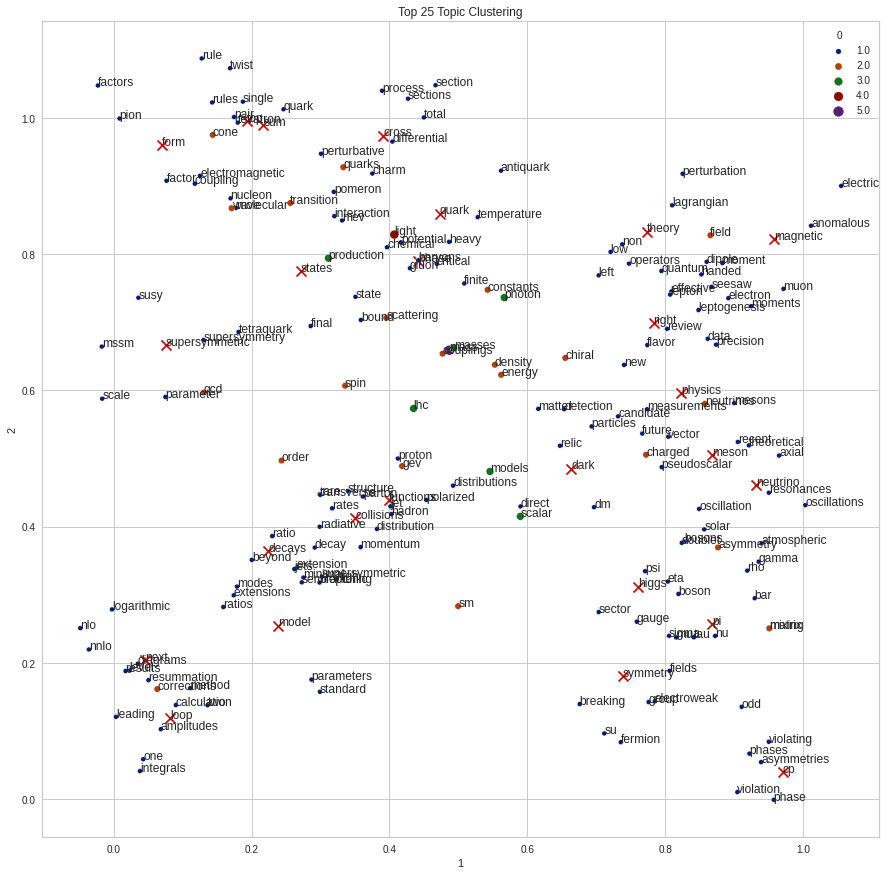

In [ ]:
queries_distances_df = pd.DataFrame(queries_distances).T
queries_distances_np = queries_distances_df.to_numpy()

fig, ax = plt.subplots()
ax.scatter(rand_points[:, 0], rand_points[:, 1], marker='x', c='r', s=100)

for i, txt in enumerate(clustered_queries.index):
    ax.annotate(txt, (rand_points[i, 0], rand_points[i, 1]))

sns.scatterplot(data=queries_distances_df, x=1, y=2, size=0, hue=0, palette='dark', ax=ax)

for i, txt in enumerate(queries_distances_df.index):
  query_row = queries_distances_df.iloc[i].to_numpy()


  ax.annotate(txt, (query_row[1], query_row[2]))


plt.gcf().set_size_inches(15, 15)
plt.title("Top 25 Topic Clustering")
plt.show()

# Section 6

## Recommender System and Topic Querying

In [ ]:
# Recommend other abstracts using cosine similarity, based on NMF W matrix
# Reference: https://www.searchenginejournal.com/topic-clusters-recommender-system/436123/

def get_recommendations(abstract_title, n_abstracts=20):
  norm_df = pd.DataFrame(W, index=arvix_dataset['title'])
  recommendations = norm_df.loc[abstract_title,:]
  similarities = norm_df.dot(recommendations)
  loop = dict(similarities.nlargest(n_abstracts)).items()
  return pd.DataFrame(loop)

ind = 4
print("Title: ", arvix_dataset['title'][ind])
get_recommendations(arvix_dataset['title'][ind])

Title:  Probing non-standard neutrino interactions with supernova neutrinos


,0,1
0,Probing non-standard neutrino interactions wit...,1.000000
1,Sterile neutrinos as a possible explanation fo...,0.957857
2,Cherenkov effect in the weak interactions gene...,0.944473
3,Constraints on the non-standard interaction in...,0.937876
4,Effect of sterile Neutrinos and Nonstandard In...,0.937259
5,VEP oscillation solutions to the solar neutrin...,0.932397
6,Searching for the MSW Enhancement,0.931622
7,Interpretation of the XENON1T excess in the mo...,0.930691
8,Pseudo Dirac Neutrinos in Seesaw Model,0.926189
9,A New Solution of the Solar Neutrino Flux,0.923889


From the observation, the highest cosine similarity is the abstract itself, while correlated papers based on the NMF factorization are given as recommendations

Finally, we make a Topic querying system, which uses cosine similarity again, as a metric for a query and the list of abstracts. Choosing the best match for a given query. Thus a query gives us the recommendations of a certain abstract, including itself

In [ ]:
class QueryPaper:
  def __init__(self):
    self.titles = arvix_dataset['title']

  def title_recommendations(self, title, n_titles=20):
    norm_df = pd.DataFrame(W, index=arvix_dataset['title'])
    recommendations = norm_df.loc[title,:]
    similarities = norm_df.dot(recommendations)
    loop = dict(similarities.nlargest(n_titles)).items()
    return pd.DataFrame(loop)

  def query_title_similarity(self, query):
    best_sim = 0
    best_title = ""
    for title in arvix_dataset['title']:
      clean_title = ' '.join(clean_abstract(title))
      clean_query = ' '.join(clean_abstract(query))
      count_vectorizer = CountVectorizer()
      vector_matrix = count_vectorizer.fit_transform([clean_title, clean_query])
      # Cosine similarity sometimes breaks because of matrix alignment for some reason, so just try catch these exceptions
      try:
        cosine_similarity_matrix = cosine_similarity(vector_matrix)
        sim = cosine_similarity_matrix[0, 1]
        if sim > best_sim:
          best_sim = sim
          best_title = title
      except:
        pass



    return [best_title,best_sim]

  def __call__(self, query):
    print(f"Query: {query}")
    best_title, best_sim = self.query_title_similarity(query)
    print(f"Found {np.round(best_sim, 3)} similarity match to: '{best_title}'")
    return self.title_recommendations(best_title)



In [ ]:
query_model = QueryPaper()


In [ ]:
query_model("Supernova neutrinos")

Query: Supernova neutrinos
Found 0.816 similarity match to: 'Neutrinos and Nucleosynthesis in Supernova'


,0,1
0,Neutrinos and Nucleosynthesis in Supernova,1.000000
1,Single neutral heavy lepton production at elec...,0.898165
2,Prospects of detecting massive isosinglet neut...,0.895500
3,Active-Sterile Neutrino Transformation and r-P...,0.894332
4,Searching for Heavy Neutrinos with the MoEDAL-...,0.882203
5,Neutrinos from Stellar Collapse: Comparison of...,0.861597
6,Explaining the MiniBooNE excess by a decaying ...,0.857652
7,Measuring the Mass Hierarchy with Muon and Had...,0.856584
8,High Energy Tau Neutrinos,0.855328
9,Charmonium production at neutrino factories,0.852255


# Section 7

## Conclusion

The application of NMF factorization as a precendant step for TFIDF is a major improvement to using TF-IDF alone, reducing memory restrictions, while also giving us key information, from a largly sparse dataset. Furthermore, NMF allows us to find similarties in words, in order to make representations of TD-IDF results, in the form of topic querying. Another benefit of NMF is it's use in making a Recommender System, similar to PCA, it finds relationships between the decomposition of the TF-IDF matrix, and uses cosine similarity as a metric for relevance between abstracts.

Considering the large dataset for just a single field hep-ph (High Energy Physics) among the ArXiv, it is clear that most of the data must be loaded beforehand, including NMF results for each field, to make it practical for real implementation. Another issue about TFiDF, it isn't robust to arrangement in documents, as a result, the example query from above "Supernova neutrinos", results it recommendations, that focus more on the "neutrino" aspect, rather than the whole phrase. Although one approach to fixing this would be using bigrams (TFIDF produces 2 word phrases, rather than just single words), neither is the abstract information reliable enough to handle two-word phrases, it doesn't fix the problem of a query with 3+ words.

Possible improvements to the model include using more modern NLP approachs, uniquely Neural Networks which have become the key application when dealing with textual information.


